In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.cosmology import Planck18
from scipy.special import erf, erfc,erfcx
import scipy
import emcee
import corner
from astropy.table import Table
from astropy.io import fits
import fitsio
import matplotlib as mpl
from multiprocessing import Pool
from fitting import abs_mag_to_L,get_lfpars_shen20,T0,T1,T2,get_lfpars,get_phis

In [2]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k.csv',format='csv')
indice = np.isnan(k['k_gg']) | np.isinf(k['k_gg']) | np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]

In [3]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.1) & (d['Z'] < 2.8))[0]
apr_mag_g = d['APP_MAG_G'][SEL][~indice]
apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z = d['Z'][SEL][~indice]

In [4]:
d = Planck18.distmod(z).value

In [5]:
def log_likelihood(params, apr_mag, magerr, z, d, k):
    x, m0 = params
    term1 = -np.log(np.sqrt(2 * np.pi) * magerr)
    term2 = -0.5 * (np.mean(apr_mag) - apr_mag)**2 / magerr**2
    L = abs_mag_to_L(apr_mag - k - d + x)
    phi = get_phis(L, z, "shen20")
    term3 = np.log(phi)
    term4 = np.where(apr_mag<m0,0,np.log(1-1/m0+1/apr_mag))
    
    total_log_likelihood = np.sum(term1 + term2 + term3 + term4)
    return total_log_likelihood

In [6]:
# Define the log prior
def log_prior(params):
    x, m0 = params
    if 0 < x < 10 and 10 < m0 < 30:  # Example ranges, adjust as necessary
        return 0.0  # log(1) for uniform prior
    return -np.inf  # log(0) outside the prior ranges

# Define the log posterior
def log_posterior(params, apr_mag, magerr, z, d, k):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, apr_mag, magerr, z, d, k)

ndim = 2  # Number of parameters
nwalkers = 100  # Number of MCMC walkers
nsteps = 4000  # Number of MCMC steps
start_pos = [2, 20] + 0.1 * np.random.randn(nwalkers, ndim)

def safe_run_mcmc():
    try:
        with Pool(processes=64) as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(apr_mag_g, apr_mag_g_err, z, d, k_gg), pool=pool)
            sampler.run_mcmc(start_pos, nsteps, progress=True)
        return sampler
    except Exception as e:
        print(f"An error occurred: {e}")
        raise

sampler_gg = safe_run_mcmc()

100%|██████████| 4000/4000 [2:01:02<00:00,  1.82s/it]  


[[ 9.99998312 23.34924481]
 [ 9.99999691 24.1677729 ]
 [ 9.99999646 27.05373005]
 ...
 [ 9.99999927 23.76572748]
 [ 9.99999273 28.72342592]
 [ 9.99999847 28.21382214]]


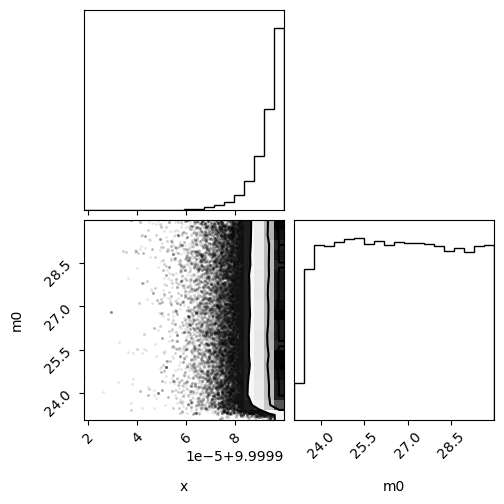

In [7]:
# Process the results
samples_gg = sampler_gg.get_chain(discard=1000, flat=True)
print(samples_gg)

# Plot the corner plot
figure = corner.corner(samples_gg, labels=["x", "m0"])
plt.show()